# Оценки отелей на Booking

## 1. Подготовка и чтение данных

In [2]:
# ЗАГРУЗКА НЕОБХОДИМЫХ БИБЛИОТЕК

# для работы с данными
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# для работы с признаками
# кодирования признаков
import category_encoders as ce
# нормализации признаков
from sklearn import preprocessing

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# импортируем библиотеки для оценки тональности текста
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time

# загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# библиотеки для работы с моделью
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели


In [6]:
# фиксируем RANDOM_SEED, для воспроизводимости эксперимента
RANDOM_SEED = 42

In [7]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы
!pip freeze > requirements.txt

In [8]:
data = pd.read_csv('C:\IDE\PROJECT-3_EDA+Feature_Engineering\data\hotels.csv')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [10]:
data.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng
count,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.00000,386803.000000,384355.000000,384355.000000
mean,498.246536,8.397231,18.538988,2743.992042,17.776985,7.17725,8.396906,49.443522,2.823402
std,500.258012,0.547881,29.703369,2316.457018,21.726141,11.05442,1.636090,3.466936,4.579043
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.00000,2.500000,41.328376,-0.369758
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.00000,7.500000,48.214662,-0.143649
50%,342.000000,8.400000,9.000000,2134.000000,11.000000,3.00000,8.800000,51.499981,-0.000250
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.00000,9.600000,51.516288,4.834443
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.00000,10.000000,52.400181,16.429233


array([[<AxesSubplot: title={'center': 'additional_number_of_scoring'}>,
        <AxesSubplot: title={'center': 'average_score'}>,
        <AxesSubplot: title={'center': 'review_total_negative_word_counts'}>],
       [<AxesSubplot: title={'center': 'total_number_of_reviews'}>,
        <AxesSubplot: title={'center': 'review_total_positive_word_counts'}>,
        <AxesSubplot: title={'center': 'total_number_of_reviews_reviewer_has_given'}>],
       [<AxesSubplot: title={'center': 'reviewer_score'}>,
        <AxesSubplot: title={'center': 'lat'}>,
        <AxesSubplot: title={'center': 'lng'}>]], dtype=object)

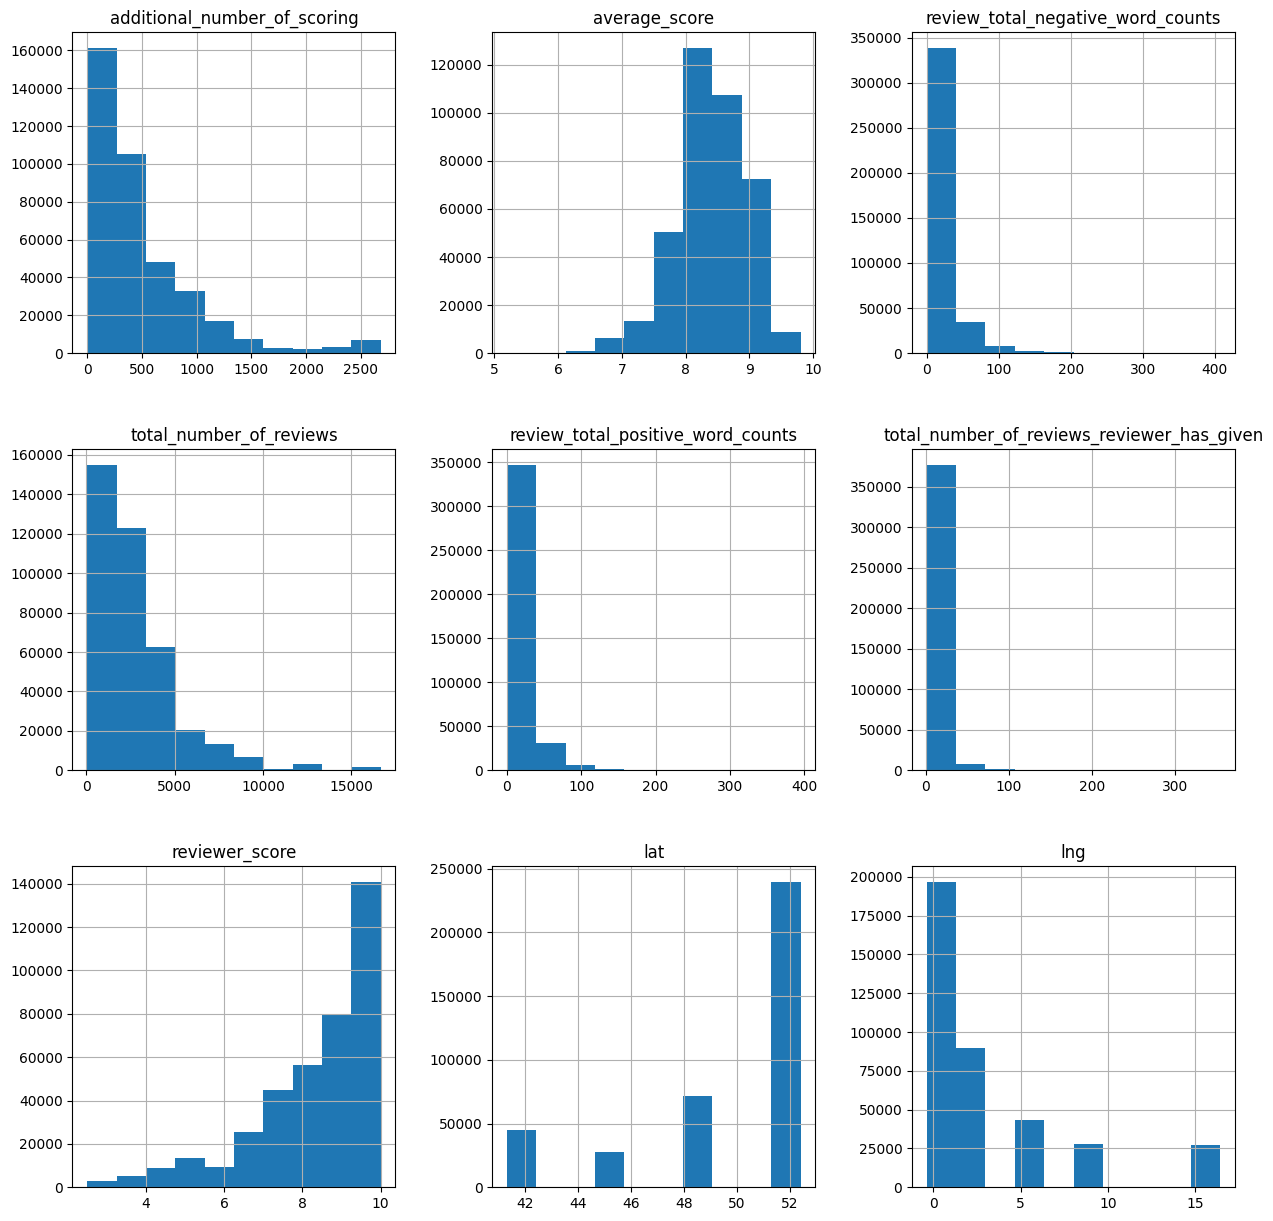

In [11]:
data.hist(figsize = (15,15))


Описание:

Признаки можно разделить на три группы:

1. Связанные с отелем признаки / Hotel Related Features (7)
* hotel_name - full hotel name;

* hotel_address - address: street, post code, city, country;

* lat - hotel latitude coordinate;

* lng - hotel longitude coordinate;

* average_score - average hotel rating;

* total_number_of_reviews - total number of hotel reviews;

* additional_number_of_scoring - number of hotel scores without review.

2. Связанные с рецензентом признаки / Reviewer Related Features (3)
* reviewer_nationality - reviewer nationality;

* total_number_of_reviews_reviewer_has_given - total number of reviews reviewer has given;

* tags - tags describing stay in the hotel.

3. Связанные с отзывом признаки / Review Related Features (6)
* review_date date of review;

* days_since_review difference in the number of days between review date and scrape date;

* negative_review text of negative review;

* review_total_negative_word_counts negative review words number;

* positive_review text of positive review;

* review_total_positive_word_counts positive review words number.

Проблемы:
1. Есть пропуски в столбцах lat и lng
2. Значение в 8 столбцах типа object, нужно с ними поработать и привести к числовому виду

## 2. Обработка признаков

In [12]:
# проверим может быть пропущенные данные по местоположению отелей можно найти в других записях
no_place = set(data[(data['lat'] == 0) | (data['lng'] == 0)]['hotel_name'].values)
yes_place = set(data[(data['lat'] != 0) & (data['lng'] != 0)]['hotel_name'].values)

no_place.intersection(yes_place) # нет данных

set()

In [13]:
# заполним пустые значения в координатах нулями
data[['lat','lng']] = data[['lat','lng']].fillna(0)

### Преобразуем признак даты отзыва (review-date)

In [14]:
# изменим значение даты на тип данных datetime
data['review_date'] = pd.to_datetime(data['review_date'], dayfirst = False, yearfirst = False)

# определим номер дня года, когда написан отзыв и создадим новый признак
data['day_of_year'] = data['review_date'].apply(lambda x: x.timetuple().tm_yday)

# выделим год отзыва
data['rewiew_year'] = data['review_date'].dt.year

In [15]:
# преобразуем информацию о времени, прошедшем с момента
# написания отзыва, в числовое значение с помощью функции:
def time_review(arg):
    word_list = arg.split() # преобразуем в список по пробелам
    for word in word_list:
        if word.isnumeric(): # выберем числовое значение
            return int(word)
        
data['days_since_review'] = data['days_since_review'].apply(time_review)

### Обрабатывание тегов

In [16]:
# из тегов выделим количество ночей проведенных клиентом в отеле
# создадим функцию, отыскивающую нужный тег и возвращающую количество дней
def days_number(arg):
    tag_list = arg.split(',')
    for tag in tag_list:
        ind = tag.find('night')
        if ind > 0:
            word_list = tag.split()
            for word in word_list:
                if word.isnumeric():
                    return int(word)
# создадим признак по времени пребывания в отеле            
data['accommodation_days'] = data['tags'].apply(days_number)

In [17]:
# создадим признак считающий количество слов в тегах
data['word_tegs_cnt'] = data['tags'].apply(lambda x: len(list(x.split(','))))

In [18]:
# удалим теги, отвечающий за количество ночей (мы уже выписали их)
# функция принимает строку, разбивает ее на теги, находит и удаляет те, в которых уrазано количество ночей возвращает список

def tags_no_nights(arg):

    k = list(arg.split(','))
    
    for tag in k:
        ind = 0
        ind = tag.find('night')
        if ind > 0:
            k.remove(tag)
            
    arg = ','.join(k)
    return arg

# очищаем теги от длительности пребывания, возможно они нам еще пригодятся (не пригодились:))
data['tags'] = data['tags'].apply(tags_no_nights)     

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 21 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               386803 non-null  object        
 1   additional_number_of_scoring                386803 non-null  int64         
 2   review_date                                 386803 non-null  datetime64[ns]
 3   average_score                               386803 non-null  float64       
 4   hotel_name                                  386803 non-null  object        
 5   reviewer_nationality                        386803 non-null  object        
 6   negative_review                             386803 non-null  object        
 7   review_total_negative_word_counts           386803 non-null  int64         
 8   total_number_of_reviews                     386803 non-null  int64        

In [20]:
# пустые значения пребывания заменим на медиану
data['accommodation_days'] = data['accommodation_days'].fillna(data['accommodation_days'].median())

### Обрабатывание текстов отзывов

In [21]:
data['negative_review'].head(10)

0                                             Leaving 
1                                       poor breakfast
2                                   No kettle in room 
3                                          No Negative
4                                         Torn sheets 
5                                              Nothing
6                               Nothing it was lovely 
7     The communal areas are a bit soul less and th...
8     undergoing refurbishment no tea coffer in roo...
9     I advised it was for my husbands birthday and...
Name: negative_review, dtype: object

В некоторых негативных отзывах указано "нет негатива", пометим их и создадим соответствующий признак

In [22]:
data['no_negative'] = data['negative_review'].apply(lambda x: 1 if x == 'No Negative' else 0)

Аналогичную операцию проводим над позитивными

In [23]:
data['positive_review'].head(10)

0                                   Staff were amazing
1                                             location
2                                          No Positive
3     Friendly staff quiet comfortable room spotles...
4     The staff was very friendly and helpful Break...
5     Very nice hotel Price is excellent when compa...
6     Very central location 2 minutes walk from Glo...
7     The location is good for transport links espe...
8                  staff very good location wonderful 
9                                          No Positive
Name: positive_review, dtype: object

In [24]:
data['no_positive'] = data['positive_review'].apply(lambda x: 1 if x == 'No Positive' else 0)

In [25]:
# из отзывов выделим эмоциональную окраску текста в отзывах
nltk.downloader.download('vader_lexicon')
sent_analyzer = SentimentIntensityAnalyzer()


# в результате обработки выдается словарь с четырьмя парами ключ:значение
# по негативным отзывам
data['negative_review'] = data['negative_review'].apply(sent_analyzer.polarity_scores)
# по позитивным отзывам
data['positive_review'] = data['positive_review'].apply(sent_analyzer.polarity_scores)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\nikol\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [26]:
# создадим новые признаки из негативнного отзыва
data['negative_neg'] = data['negative_review'].apply(lambda x: x['neg'])
data['negative_neu'] = data['negative_review'].apply(lambda x: x['neu'])
data['negative_pos'] = data['negative_review'].apply(lambda x: x['pos'])
data['negative_compound'] = data['negative_review'].apply(lambda x: x['compound'])

# создадим новые признаки из позитивного отзыва
data['positive_neg'] = data['positive_review'].apply(lambda x: x['neg'])
data['positive_neu'] = data['positive_review'].apply(lambda x: x['neu'])
data['positive_pos'] = data['positive_review'].apply(lambda x: x['pos'])
data['positive_compound'] = data['positive_review'].apply(lambda x: x['compound'])

In [27]:
# удалим ненужные теперь признаки отзывов
data.drop(['negative_review', 'positive_review'], axis=1, inplace=True)

### Обрабатывание признака адреса отеля

In [28]:
# города местоположения отелей
data['city_name'] = data['hotel_address'].apply(lambda x: x.split()[-2] if x.split()[-2] != 'United' else x.split()[-5]) 

In [29]:
data['city_name'].value_counts()

London       196774
Barcelona     45132
Paris         44830
Amsterdam     43006
Vienna        29178
Milan         27883
Name: city_name, dtype: int64

In [30]:
# можно использовать One-Hot-Coding

encoder = ce.OneHotEncoder(cols=['city_name'], use_cat_names=True) # указываем столбец для кодирования 
type_bin = encoder.fit_transform(data['city_name']) 
data = pd.concat([data, type_bin], axis=1)

Зная город, можно использовать данные по его расположению для заполнения пропущенных координат

In [31]:
data[(data['city_name'] == 'Amsterdam') & (data['lat'] == 0)].fillna({'lat':52.362209,'lng':4.885346})
data[(data['city_name'] == 'Barcelona') & (data['lat'] == 0)].fillna({'lat':41.389125,'lng':2.169152})
data[(data['city_name'] == 'London') & (data['lat'] == 0)].fillna({'lat':51.510737,'lng':-0.139075})
data[(data['city_name'] == 'Milan') & (data['lat'] == 0)].fillna({'lat':45.479619,'lng':9.191844})
data[(data['city_name'] == 'Paris') & (data['lat'] == 0)].fillna({'lat':48.863658,'lng':2.326816})
data[(data['city_name'] == 'Vienna') & (data['lat'] == 0)].fillna({'lat':48.203368,'lng':16.367176}) 

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,...,positive_neu,positive_pos,positive_compound,city_name,city_name_London,city_name_Paris,city_name_Amsterdam,city_name_Milan,city_name_Vienna,city_name_Barcelona
122,Savoyenstra e 2 16 Ottakring 1160 Vienna Austria,86,2016-08-26,8.3,Austria Trend Hotel Schloss Wilhelminenberg Wien,United States of America,3,1558,7,3,...,0.588,0.000,-0.5423,Vienna,0,0,0,0,1,0
724,Josefst dter Stra e 10 12 08 Josefstadt 1080 V...,333,2015-08-06,8.3,Fleming s Selection Hotel Wien City,United Arab Emirates,8,3672,13,4,...,0.476,0.524,0.8720,Vienna,0,0,0,0,1,0
754,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,214,2016-01-04,7.8,Hotel Atlanta,Romania,0,2724,8,26,...,0.690,0.310,0.4019,Vienna,0,0,0,0,1,0
1189,Sieveringer Stra e 4 19 D bling 1190 Vienna Au...,115,2017-06-27,8.0,Derag Livinghotel Kaiser Franz Joseph Vienna,Egypt,4,1496,6,6,...,0.556,0.444,0.4927,Vienna,0,0,0,0,1,0
1193,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,211,2016-06-14,8.6,Hotel City Central,United Kingdom,4,2923,12,1,...,0.556,0.444,0.7506,Vienna,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386054,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,214,2015-11-21,7.8,Hotel Atlanta,Estonia,0,2724,31,15,...,0.752,0.197,0.7038,Vienna,0,0,0,0,1,0
386092,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,211,2017-03-19,8.6,Hotel City Central,India,11,2923,7,2,...,0.323,0.677,0.7425,Vienna,0,0,0,0,1,0
386465,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,211,2017-07-04,8.6,Hotel City Central,United Kingdom,24,2923,6,10,...,0.519,0.481,0.5719,Vienna,0,0,0,0,1,0
386702,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,211,2016-11-07,8.6,Hotel City Central,Italy,0,2923,19,6,...,0.521,0.479,0.9179,Vienna,0,0,0,0,1,0


In [32]:
data['lat'].unique

<bound method Series.unique of 0         51.507894
1         51.521009
2         48.845377
3         48.888697
4         52.385601
            ...    
386798    51.494028
386799    48.192379
386800    51.520795
386801    51.515125
386802    51.493109
Name: lat, Length: 386803, dtype: float64>

### Обрабатывание признака названия отеля

In [33]:
data['hotel_name'].nunique()

1492

In [34]:
# Можем использовать бинарное кодирование
bin_encoder = ce.BinaryEncoder(cols=['hotel_name']) # указываем столбец для кодирования 
type_bin = bin_encoder.fit_transform(data['hotel_name']) 
data = pd.concat([data, type_bin], axis=1)

Далее обработаем признак страны рецензента с учётом адреса отеля

In [35]:
# введем признак страны для отелей
data['country'] = data['hotel_address'].apply(lambda x: x.split()[-1] if x.split()[-1] != 'Kingdom' else ' '.join(x.split()[-2:]))

# уберем пробелы в названии места жительства рецензента
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x[1:-1])

# создадим признак,определяющий иностранец или местный писал отзыв
data['local_reviewer'] = data.apply(lambda x: 1 if x['reviewer_nationality'] == x['country'] else 0, axis=1)

data['local_reviewer'].value_counts(normalize=True)

0    0.653723
1    0.346277
Name: local_reviewer, dtype: float64

In [36]:
data['reviewer_nationality'].nunique(dropna=False)

225

In [37]:
# применим бинарное колдирование к признаку 'reviewer_nationality'
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality'])
type_bin = bin_encoder.fit_transform(data['reviewer_nationality'])

data = pd.concat([data, type_bin], axis=1)

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 57 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               386803 non-null  object        
 1   additional_number_of_scoring                386803 non-null  int64         
 2   review_date                                 386803 non-null  datetime64[ns]
 3   average_score                               386803 non-null  float64       
 4   hotel_name                                  386803 non-null  object        
 5   reviewer_nationality                        386803 non-null  object        
 6   review_total_negative_word_counts           386803 non-null  int64         
 7   total_number_of_reviews                     386803 non-null  int64         
 8   review_total_positive_word_counts           386803 non-null  int64        

In [39]:
# подготовим копию
data_copied = data.copy()

## 3. Отбор признаков

### Оценка мультиколлинеарности признаков

C:\Users\nikol\AppData\Local\Temp\ipykernel_18748\2048053009.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True)


<AxesSubplot: >

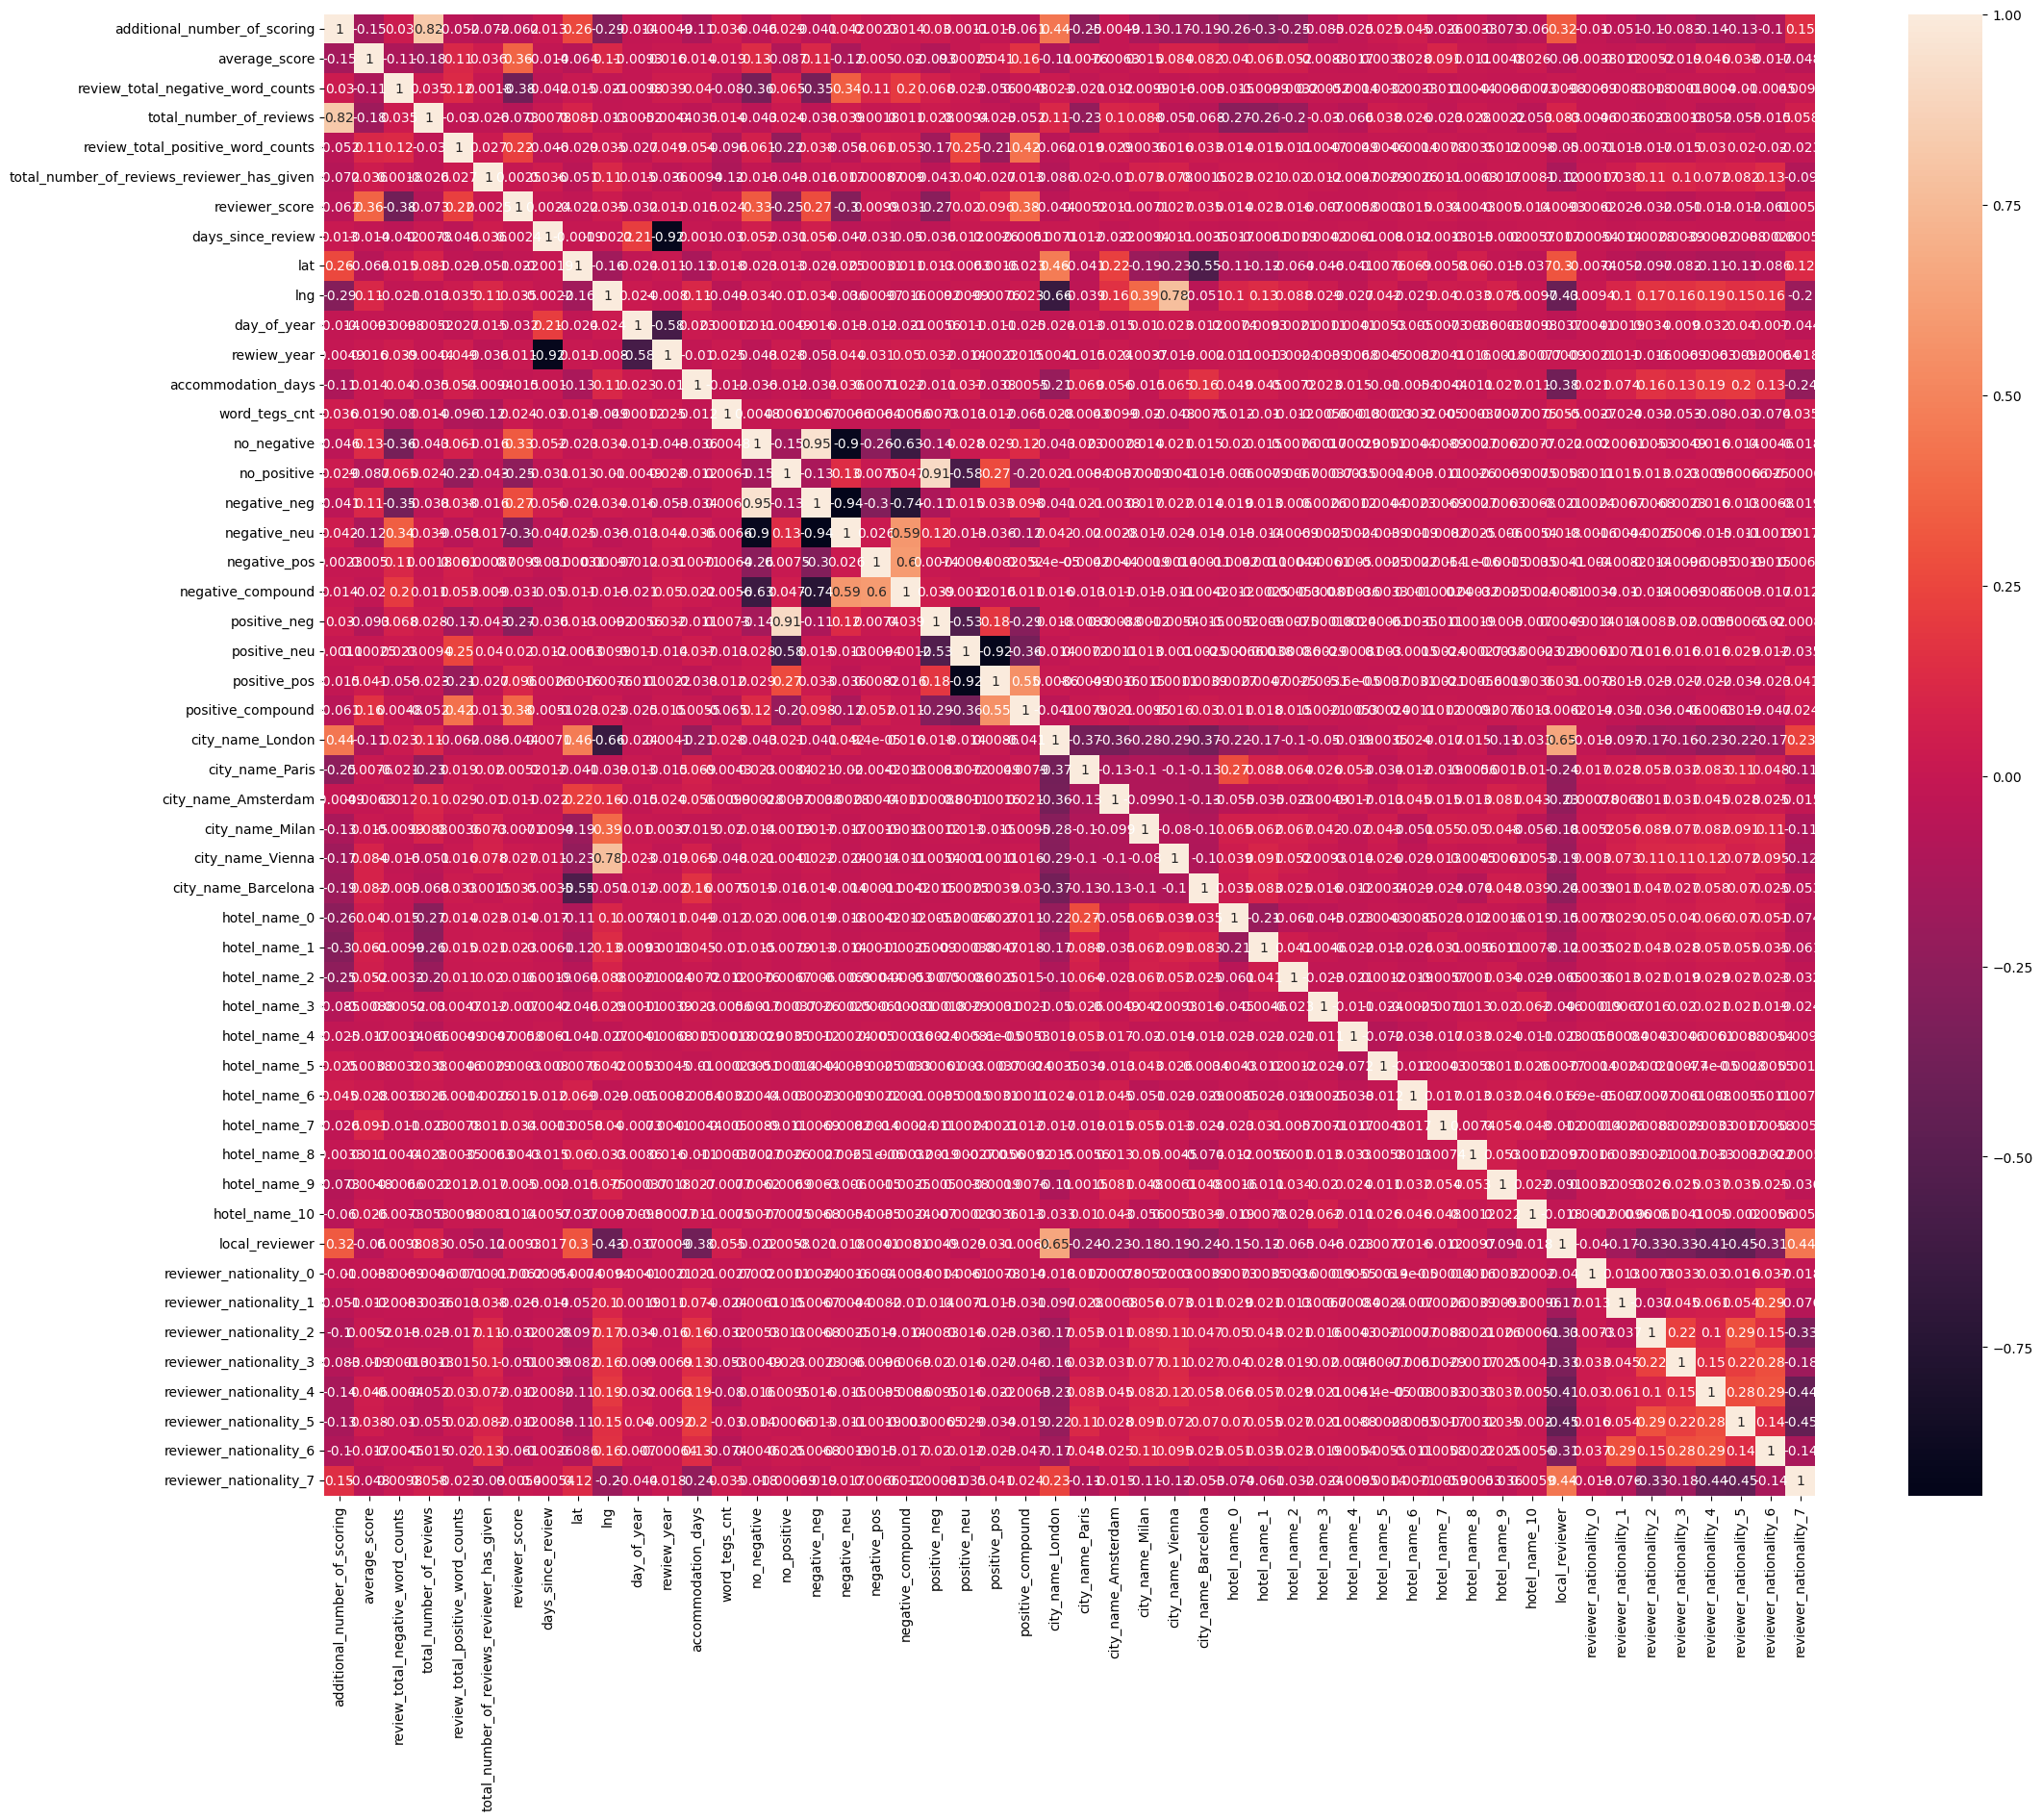

In [40]:
plt.rcParams['figure.figsize'] = (25,20)
sns.heatmap(data.corr(), annot=True)


Из чего можем заметить высокую корреляция между days_since_review - rewiew_year(-0.92), negative_neg - negative_neu (-0.94),negative_neg - 'no_negative' (0,95), negative_neu - 'no_negative' (0,9), positive_pos - positive_neu(-0.92) и positive_neg - 'no_positive' (0,91)

In [89]:
# выберем признаки из пар с высоким уровнем корреляции

data.drop('rewiew_year', axis = 1, inplace=True) 

data.drop('no_negative', axis = 1, inplace=True) 

In [90]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)
data.drop('review_date', axis = 1, inplace=True)

In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 48 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386803 non-null  int64  
 1   average_score                               386803 non-null  float64
 2   review_total_negative_word_counts           386803 non-null  int64  
 3   total_number_of_reviews                     386803 non-null  int64  
 4   review_total_positive_word_counts           386803 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 6   reviewer_score                              386803 non-null  float64
 7   days_since_review                           386803 non-null  int64  
 8   lat                                         386803 non-null  float64
 9   lng                                         386803 non-null  float64
 

In [92]:
data.head()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,lat,lng,...,hotel_name_10,local_reviewer,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7
0,581,8.4,3,1994,4,7,10.0,531,51.507894,-0.143671,...,1,1,0,0,0,0,0,0,0,1
1,299,8.3,3,1361,2,14,6.3,203,51.521009,-0.123097,...,0,1,0,0,0,0,0,0,0,1
2,32,8.9,6,406,0,14,7.5,289,48.845377,2.325643,...,1,0,0,0,0,0,0,0,1,0
3,34,7.5,0,607,11,8,10.0,681,48.888697,2.394540,...,0,0,0,0,0,0,0,0,0,1
4,914,8.5,4,7586,20,10,9.6,516,52.385601,4.847060,...,1,0,0,0,0,0,0,0,1,1


In [93]:
data.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,lat,lng,...,hotel_name_10,local_reviewer,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7
count,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.00000,386803.000000,386803.000000,386803.000000,386803.000000,...,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000
mean,498.246536,8.397231,18.538988,2743.992042,17.776985,7.17725,8.396906,354.387978,49.130604,2.805533,...,0.481416,0.346277,0.003087,0.049079,0.185467,0.195596,0.262736,0.323322,0.184290,0.706895
std,500.258012,0.547881,29.703369,2316.457018,21.726141,11.05442,1.636090,208.975174,5.226613,4.570018,...,0.499655,0.475783,0.055474,0.216034,0.388676,0.396659,0.440121,0.467745,0.387721,0.455187
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.00000,2.500000,0.000000,0.000000,-0.369758,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.00000,7.500000,175.000000,48.212857,-0.143372,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,342.000000,8.400000,9.000000,2134.000000,11.000000,3.00000,8.800000,353.000000,51.499981,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.00000,9.600000,527.000000,51.516288,4.831098,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.00000,10.000000,730.000000,52.400181,16.429233,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 3. Машинное обучение

In [94]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = data.drop(['reviewer_score'], axis = 1)  
y = data['reviewer_score'] 

In [95]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [97]:
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  

## 4. Эффективность модели

In [98]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12534514787417875


### Определим степень значимости признаков в обучении модели

''

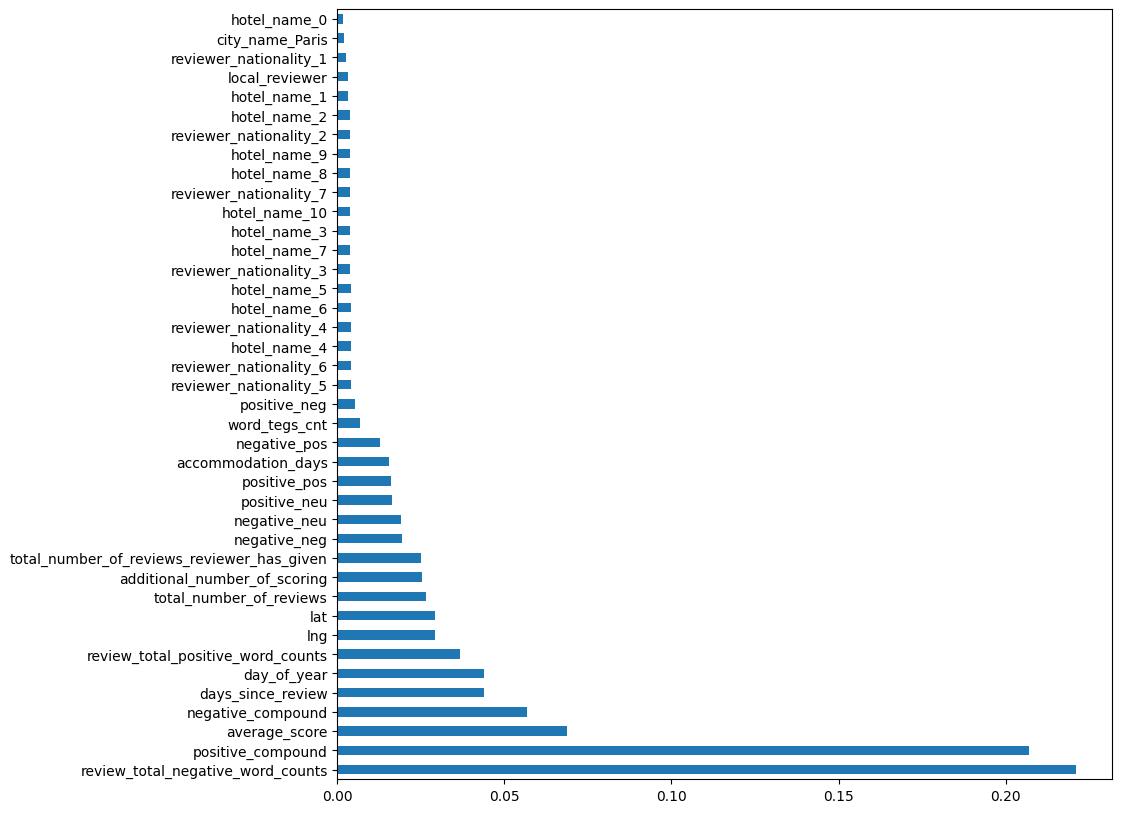

In [101]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(40).plot(kind='barh')
